# Corn Disease Classifier

##### find the dataset here: https://www.kaggle.com/datasets/salmasyed1360/plant-diseases-100k-labelled-images

In [ ]:
DATA_PATH = "set_your_data_path_here"

In [ ]:
import os
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam import GradCAM
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import random

IMG_SIZE = 260
BATCH_SIZE = 16
EPOCHS_STAGE1 = 10
EPOCHS_STAGE2 = 15

IMAGE_DIR = "../test-images/corn"
MODEL_PATH = "../models/corn_model.pth"
os.makedirs(os.path.dirname(MODEL_PATH), exist_ok=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

Device: cuda


# Data augmentation

In [3]:

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.75, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomAffine(degrees=15, translate=(0.15, 0.15), scale=(0.85, 1.15), shear=10),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

train_ds = datasets.ImageFolder(DATA_PATH, transform=train_transforms)

val_split = int(0.2 * len(train_ds))
train_len = len(train_ds) - val_split
train_set, val_set = torch.utils.data.random_split(train_ds, [train_len, val_split])

val_set.dataset.transform = val_transforms

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

class_names = train_ds.classes
num_classes = len(class_names)
print("Classes:", class_names)

Classes: ['Corn_Common_rust', 'Corn_Northern_Leaf_Blight', 'Corn_cercospora_gray_leaf_spot', 'Corn_healthy']


# Load Base Model

In [4]:
model = timm.create_model('efficientnet_b2', pretrained=True)
in_features = model.classifier.in_features
# model.classifier = nn.Linear(in_features, num_classes)
model.classifier = nn.Sequential(
    nn.Dropout(p=0.4, inplace=True),
    nn.Linear(in_features, num_classes)
)
model = model.to(DEVICE)

# Freeze base model parameters
for name, param in model.named_parameters():
    if "classifier" not in name:
        param.requires_grad = False

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.3)

# Training Base Model On Our Own Daataset

In [5]:
def train_model(model, train_loader, val_loader, epochs, stage):
    train_acc_list, val_acc_list, train_loss_list, val_loss_list = [], [], [], []
    patience_counter = 0
    patience_limit = 5
    best_acc = 0

    for epoch in range(epochs):
        # training phase
        model.train()
        running_loss, correct, total = 0, 0, 0
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", ncols=120)

        for imgs, labels in train_bar:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            out = model(imgs)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = torch.argmax(out, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            train_loss = running_loss / (len(train_bar))
            train_acc = correct / total
            current_lr = optimizer.param_groups[0]['lr']

            train_bar.set_postfix_str(f"loss={train_loss:.4f} | accuracy={train_acc:.2f}")

        # validation phase
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
                out = model(imgs)
                loss = criterion(out, labels)
                val_loss += loss.item()
                val_correct += (torch.argmax(out, 1) == labels).sum().item()
                val_total += labels.size(0)
        val_acc = val_correct / val_total
        val_loss_avg = val_loss / len(val_loader)

        train_loss_list.append(round(train_loss, 4))
        val_loss_list.append(round(val_loss_avg, 4))
        train_acc_list.append(round(train_acc * 100, 2))
        val_acc_list.append(round(val_acc * 100, 2))

        print(f"\t\t Train: loss={train_loss:.4f}, acc={train_acc:.2f} | "
                f"Val: loss={val_loss_avg:.4f}, acc={val_acc:.2f} | lr={current_lr:.2e}")

        scheduler.step(val_loss_avg)
        if val_acc > best_acc:
            best_acc = val_acc
            patience_counter = 0
            torch.save({
                'model_state_dict': model.state_dict(),
                'class_names': class_names,
                'val_acc': best_acc,
                'epoch': epoch + 1
            }, MODEL_PATH)
        else:
            patience_counter += 1
        
        if patience_counter >= patience_limit:
            print(f"★ Early stopping triggered at epoch {epoch+1}")
            break
        
    print(f"★ Saved Model With Best Validation Accuracy: {best_acc*100:.2f}%")

    return train_loss_list, val_loss_list, train_acc_list, val_acc_list


In [6]:
# Stage 1: Training top layer only
stage1_train_loss, stage1_val_loss, stage1_train_acc, stage1_val_acc = train_model(model, train_loader, val_loader, EPOCHS_STAGE1, stage=1)

Epoch 1/10: 100%|████████████████████████████████████████| 366/366 [01:23<00:00,  4.37it/s, loss=0.6027 | accuracy=0.90]


		 Train: loss=0.6027, acc=0.90 | Val: loss=0.4581, acc=0.97 | lr=1.00e-03


Epoch 2/10: 100%|████████████████████████████████████████| 366/366 [01:03<00:00,  5.77it/s, loss=0.5037 | accuracy=0.94]


		 Train: loss=0.5037, acc=0.94 | Val: loss=0.4500, acc=0.97 | lr=1.00e-03


Epoch 3/10: 100%|████████████████████████████████████████| 366/366 [01:04<00:00,  5.68it/s, loss=0.5022 | accuracy=0.94]


		 Train: loss=0.5022, acc=0.94 | Val: loss=0.4387, acc=0.97 | lr=1.00e-03


Epoch 4/10: 100%|████████████████████████████████████████| 366/366 [01:08<00:00,  5.31it/s, loss=0.4959 | accuracy=0.95]


		 Train: loss=0.4959, acc=0.95 | Val: loss=0.4379, acc=0.97 | lr=1.00e-03


Epoch 5/10: 100%|████████████████████████████████████████| 366/366 [01:00<00:00,  6.08it/s, loss=0.4931 | accuracy=0.95]


		 Train: loss=0.4931, acc=0.95 | Val: loss=0.4387, acc=0.97 | lr=1.00e-03


Epoch 6/10: 100%|████████████████████████████████████████| 366/366 [01:02<00:00,  5.89it/s, loss=0.4968 | accuracy=0.95]


		 Train: loss=0.4968, acc=0.95 | Val: loss=0.4383, acc=0.97 | lr=1.00e-03


Epoch 7/10: 100%|████████████████████████████████████████| 366/366 [01:01<00:00,  5.96it/s, loss=0.4892 | accuracy=0.95]


		 Train: loss=0.4892, acc=0.95 | Val: loss=0.4379, acc=0.97 | lr=1.00e-03


Epoch 8/10: 100%|████████████████████████████████████████| 366/366 [00:42<00:00,  8.67it/s, loss=0.4875 | accuracy=0.95]


		 Train: loss=0.4875, acc=0.95 | Val: loss=0.4362, acc=0.97 | lr=3.00e-04


Epoch 9/10: 100%|████████████████████████████████████████| 366/366 [00:34<00:00, 10.63it/s, loss=0.4852 | accuracy=0.95]


		 Train: loss=0.4852, acc=0.95 | Val: loss=0.4339, acc=0.97 | lr=3.00e-04
★ Early stopping triggered at epoch 9
★ Saved Model With Best Validation Accuracy: 97.20%


In [7]:
# Stage 2: Fine tuning last 80 layers of the base model to get better performance on the rice dataset speciifically.
for name, param in list(model.named_parameters())[-160:]:
    param.requires_grad = True

optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4)
stage2_train_loss, stage2_val_loss, stage2_train_acc, stage2_val_acc = train_model(model, train_loader, val_loader, EPOCHS_STAGE2, stage=2)

Epoch 1/15: 100%|████████████████████████████████████████| 366/366 [01:19<00:00,  4.63it/s, loss=0.4707 | accuracy=0.97]


		 Train: loss=0.4707, acc=0.97 | Val: loss=0.4187, acc=0.98 | lr=1.00e-05


Epoch 2/15: 100%|████████████████████████████████████████| 366/366 [00:52<00:00,  6.94it/s, loss=0.4450 | accuracy=0.98]


		 Train: loss=0.4450, acc=0.98 | Val: loss=0.4090, acc=0.98 | lr=1.00e-05


Epoch 3/15: 100%|████████████████████████████████████████| 366/366 [01:18<00:00,  4.64it/s, loss=0.4335 | accuracy=0.98]


		 Train: loss=0.4335, acc=0.98 | Val: loss=0.4020, acc=0.99 | lr=1.00e-05


Epoch 4/15: 100%|████████████████████████████████████████| 366/366 [00:53<00:00,  6.80it/s, loss=0.4176 | accuracy=0.99]


		 Train: loss=0.4176, acc=0.99 | Val: loss=0.3967, acc=0.99 | lr=1.00e-05


Epoch 5/15: 100%|████████████████████████████████████████| 366/366 [01:16<00:00,  4.77it/s, loss=0.4137 | accuracy=0.99]


		 Train: loss=0.4137, acc=0.99 | Val: loss=0.3914, acc=0.99 | lr=1.00e-05


Epoch 6/15: 100%|████████████████████████████████████████| 366/366 [00:50<00:00,  7.30it/s, loss=0.4055 | accuracy=0.99]


		 Train: loss=0.4055, acc=0.99 | Val: loss=0.3888, acc=0.99 | lr=1.00e-05


Epoch 7/15: 100%|████████████████████████████████████████| 366/366 [01:21<00:00,  4.50it/s, loss=0.4010 | accuracy=0.99]


		 Train: loss=0.4010, acc=0.99 | Val: loss=0.3862, acc=0.99 | lr=1.00e-05


Epoch 8/15: 100%|████████████████████████████████████████| 366/366 [00:48<00:00,  7.48it/s, loss=0.3962 | accuracy=1.00]


		 Train: loss=0.3962, acc=1.00 | Val: loss=0.3841, acc=0.99 | lr=1.00e-05


Epoch 9/15: 100%|████████████████████████████████████████| 366/366 [01:18<00:00,  4.64it/s, loss=0.3923 | accuracy=1.00]


		 Train: loss=0.3923, acc=1.00 | Val: loss=0.3803, acc=0.99 | lr=1.00e-05


Epoch 10/15: 100%|███████████████████████████████████████| 366/366 [00:51<00:00,  7.05it/s, loss=0.3884 | accuracy=1.00]


		 Train: loss=0.3884, acc=1.00 | Val: loss=0.3775, acc=0.99 | lr=1.00e-05


Epoch 11/15: 100%|███████████████████████████████████████| 366/366 [01:17<00:00,  4.72it/s, loss=0.3826 | accuracy=1.00]


		 Train: loss=0.3826, acc=1.00 | Val: loss=0.3763, acc=0.99 | lr=1.00e-05


Epoch 12/15: 100%|███████████████████████████████████████| 366/366 [00:53<00:00,  6.79it/s, loss=0.3811 | accuracy=1.00]


		 Train: loss=0.3811, acc=1.00 | Val: loss=0.3738, acc=0.99 | lr=1.00e-05


Epoch 13/15: 100%|███████████████████████████████████████| 366/366 [00:50<00:00,  7.32it/s, loss=0.3780 | accuracy=1.00]


		 Train: loss=0.3780, acc=1.00 | Val: loss=0.3734, acc=0.99 | lr=1.00e-05


Epoch 14/15: 100%|███████████████████████████████████████| 366/366 [00:40<00:00,  9.03it/s, loss=0.3749 | accuracy=1.00]


		 Train: loss=0.3749, acc=1.00 | Val: loss=0.3736, acc=0.99 | lr=1.00e-05


Epoch 15/15: 100%|███████████████████████████████████████| 366/366 [00:36<00:00, 10.00it/s, loss=0.3741 | accuracy=1.00]


		 Train: loss=0.3741, acc=1.00 | Val: loss=0.3716, acc=1.00 | lr=1.00e-05
★ Saved Model With Best Validation Accuracy: 99.52%


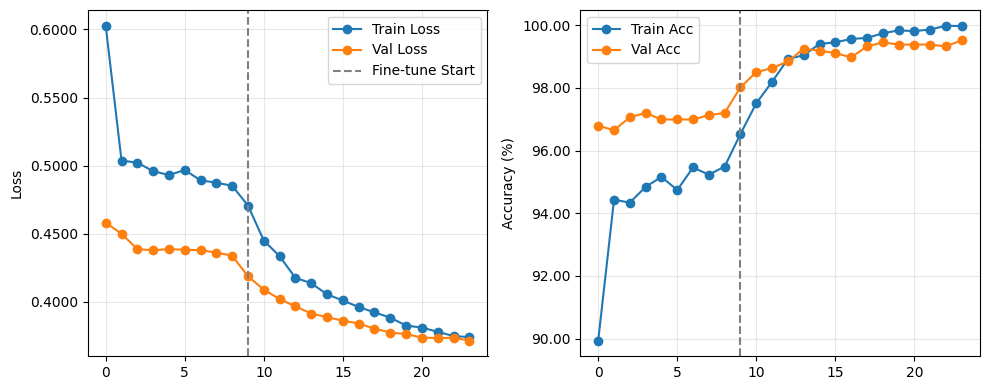

    epoch  train_loss  val_loss  train_acc  val_acc
0       1      0.6027    0.4581      89.94    96.79
1       2      0.5037    0.4500      94.43    96.65
2       3      0.5022    0.4387      94.34    97.06
3       4      0.4959    0.4379      94.84    97.20
4       5      0.4931    0.4387      95.16    96.99
5       6      0.4968    0.4383      94.74    96.99
6       7      0.4892    0.4379      95.46    96.99
7       8      0.4875    0.4362      95.23    97.13
8       9      0.4852    0.4339      95.49    97.20
9      10      0.4707    0.4187      96.53    98.02
10     11      0.4450    0.4090      97.51    98.50
11     12      0.4335    0.4020      98.19    98.63
12     13      0.4176    0.3967      98.92    98.84
13     14      0.4137    0.3914      99.04    99.25
14     15      0.4055    0.3888      99.40    99.18
15     16      0.4010    0.3862      99.45    99.11
16     17      0.3962    0.3841      99.56    98.97
17     18      0.3923    0.3803      99.59    99.32
18     19   

In [8]:
train_loss_full = stage1_train_loss + stage2_train_loss
val_loss_full = stage1_val_loss + stage2_val_loss
train_acc_full = stage1_train_acc + stage2_train_acc
val_acc_full = stage1_val_acc + stage2_val_acc

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_loss_full, label="Train Loss", marker='o')
plt.plot(val_loss_full, label="Val Loss", marker='o')
plt.axvline(x=len(stage1_train_loss), color='gray', linestyle='--', label="Fine-tune Start")
plt.ylabel("Loss"); plt.legend(); plt.grid(True, alpha=0.3)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.4f}'))

plt.subplot(1,2,2)
plt.plot(train_acc_full, label="Train Acc", marker='o')
plt.plot(val_acc_full, label="Val Acc", marker='o')
plt.axvline(x=len(stage1_train_acc), color='gray', linestyle='--')
plt.ylabel("Accuracy (%)"); plt.legend(); plt.grid(True, alpha=0.3)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.2f}'))

plt.tight_layout()
plt.show()

metrics = {
    "epoch": list(range(1, len(train_loss_full)+1)),
    "train_loss": train_loss_full,
    "val_loss": val_loss_full,
    "train_acc": train_acc_full,
    "val_acc": val_acc_full
}

print(pd.DataFrame(metrics))


# Model Evaluation


★ Overall Accuracy: 99.52%
★ Macro F1-score:   99.47%
★ Weighted F1-score:99.52%


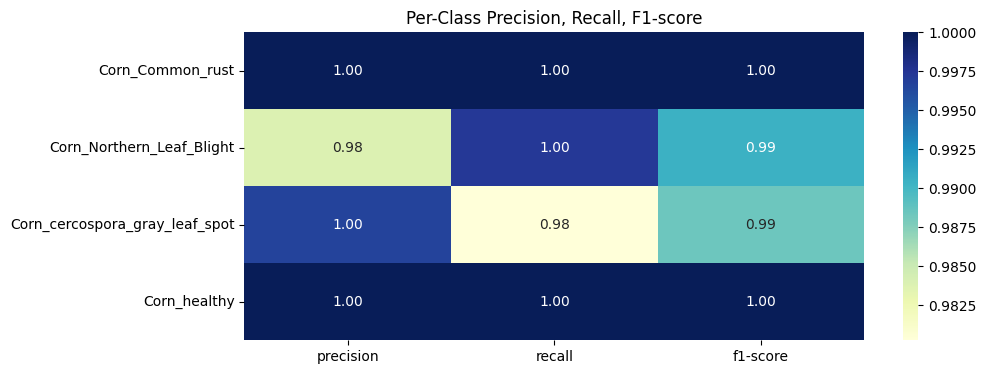

In [9]:
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        outputs = model(imgs)
        preds = torch.argmax(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

report_dict = classification_report(
    y_true, y_pred, target_names=class_names, output_dict=True
)
report_df = pd.DataFrame(report_dict).transpose()

overall_acc = accuracy_score(y_true, y_pred)
macro_f1 = report_dict['macro avg']['f1-score']
weighted_f1 = report_dict['weighted avg']['f1-score']

print(f"\n★ Overall Accuracy: {overall_acc*100:.2f}%")
print(f"★ Macro F1-score:   {macro_f1*100:.2f}%")
print(f"★ Weighted F1-score:{weighted_f1*100:.2f}%")

plt.figure(figsize=(10,4))
sns.heatmap(report_df.iloc[:-3, :-1], annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Per-Class Precision, Recall, F1-score")
plt.yticks(rotation=0)
plt.show()

In [10]:
# plt.figure(figsize=(10,5))
# plt.bar(class_names, report_df.loc[class_names, "f1-score"], color="teal")
# plt.xticks(rotation=60, ha='right')
# plt.ylabel("F1-score")
# plt.title("F1-score per Class")
# plt.grid(axis='y', linestyle='--', alpha=0.6)
# plt.show()

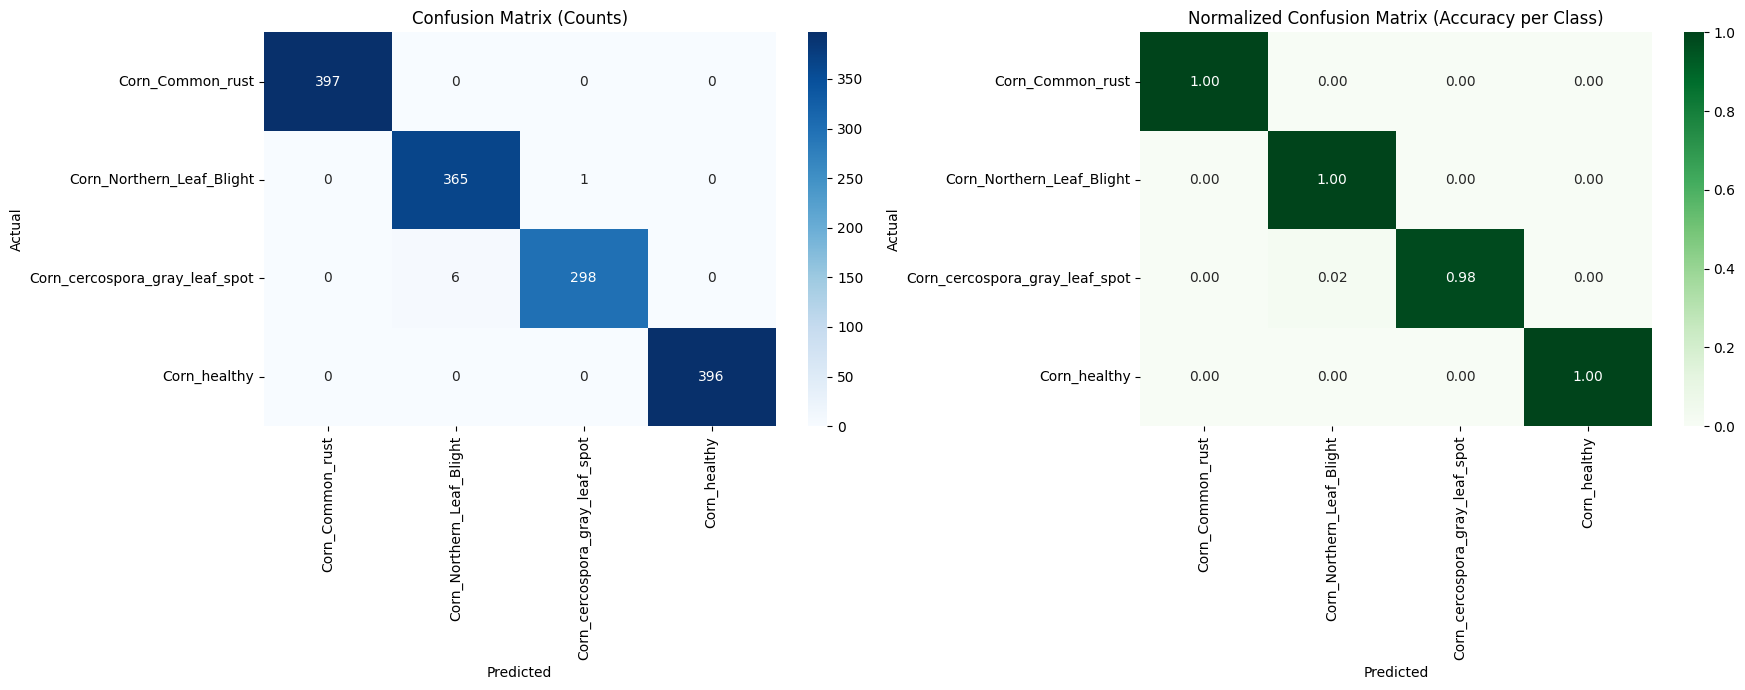

In [11]:
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(1, 2, figsize=(18,7))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=ax[0])
ax[0].set_title("Confusion Matrix (Counts)")
ax[0].set_xlabel("Predicted")
ax[0].set_ylabel("Actual")

sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Greens',
            xticklabels=class_names, yticklabels=class_names, ax=ax[1])
ax[1].set_title("Normalized Confusion Matrix (Accuracy per Class)")
ax[1].set_xlabel("Predicted")
ax[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.980906..2.2391288].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8044444..2.1519828].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.68244..1.907974].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7870152..1.6324171].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7347276..1.9064132].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7521569..1.4306723].


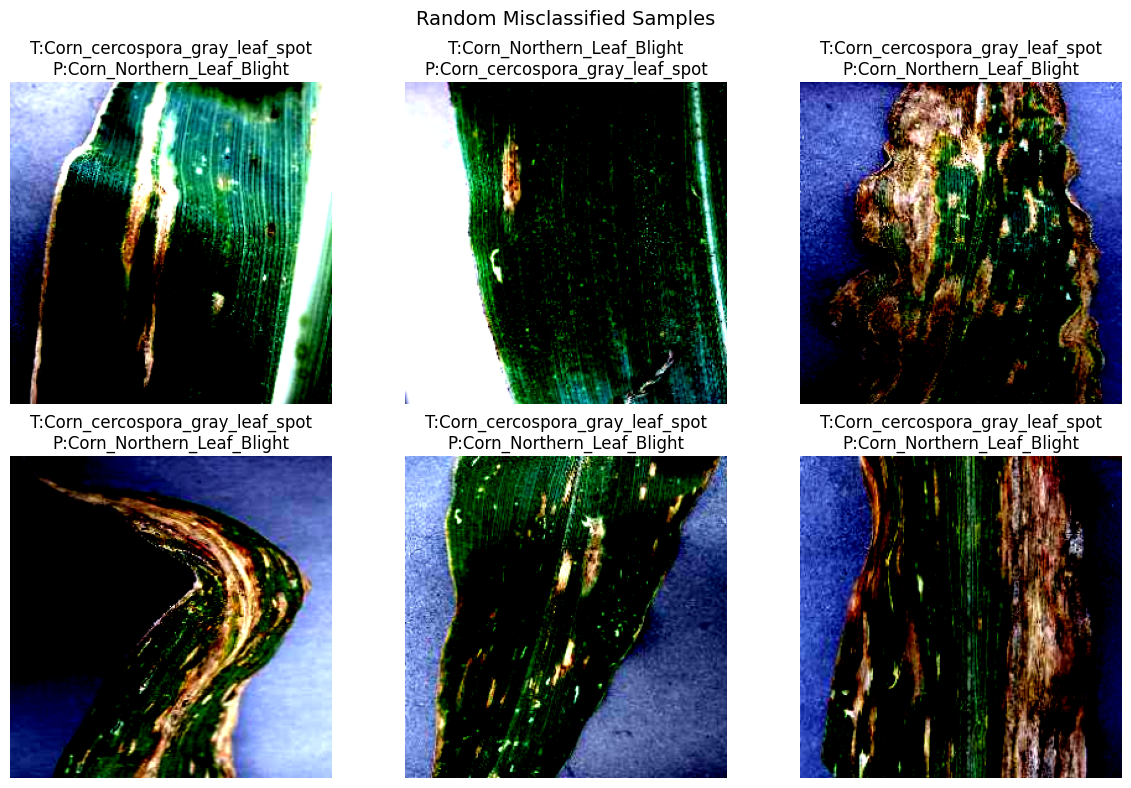

In [12]:
mis_idx = [i for i in range(len(y_true)) if y_true[i] != y_pred[i]]

if len(mis_idx) > 0:
    sample_mis = random.sample(mis_idx, min(6, len(mis_idx)))
    fig, axes = plt.subplots(2, 3, figsize=(12,8))
    axes = axes.flatten()
    dataset = val_loader.dataset
    
    for j, idx in enumerate(sample_mis):
        img, label = dataset[idx]
        pred_label = y_pred[idx]
        axes[j].imshow(np.transpose(img.numpy(), (1,2,0)))
        axes[j].set_title(f"T:{class_names[label]}\nP:{class_names[pred_label]}")
        axes[j].axis("off")
        
    plt.suptitle("Random Misclassified Samples", fontsize=14)
    plt.tight_layout()
    plt.show()

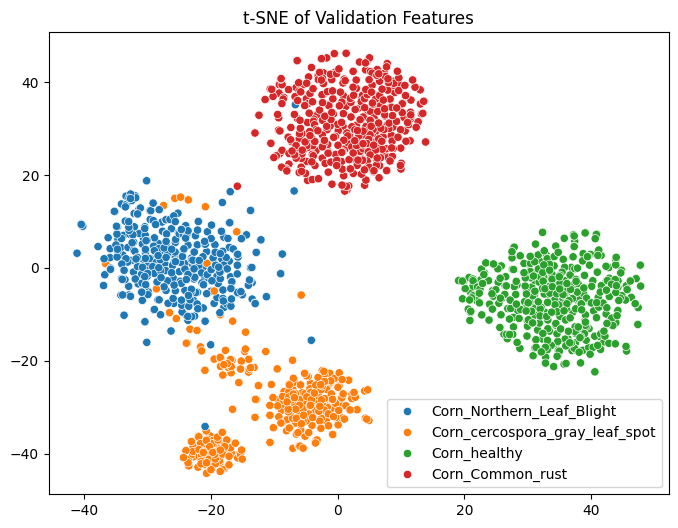

In [13]:
# Feature Embeddings (t-SNE or PCA)
from sklearn.manifold import TSNE

features, labels = [], []
with torch.no_grad():
    for imgs, lbls in val_loader:
        imgs = imgs.to(DEVICE)
        feats = model.forward_features(imgs)
        features.append(feats.mean(dim=[2,3]).cpu().numpy())
        labels.extend(lbls.numpy())

features = np.concatenate(features, axis=0)
labels = np.array(labels)

tsne = TSNE(n_components=2, random_state=42).fit_transform(features)
plt.figure(figsize=(8,6))
sns.scatterplot(x=tsne[:,0], y=tsne[:,1], hue=[class_names[l] for l in labels], palette="tab10")
plt.title("t-SNE of Validation Features")
plt.show()


# Testing Model Predictions On New Leaves

In [ ]:
checkpoint = torch.load(MODEL_PATH, map_location=DEVICE)
class_names = checkpoint['class_names']
num_classes = len(class_names)

model = timm.create_model('efficientnet_b2', pretrained=False, num_classes=num_classes)
in_features = model.classifier.in_features
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.4, inplace=True),
    torch.nn.Linear(in_features, num_classes)
)
model.load_state_dict(checkpoint['model_state_dict'], strict=False)
model = model.to(DEVICE)
model.eval()

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

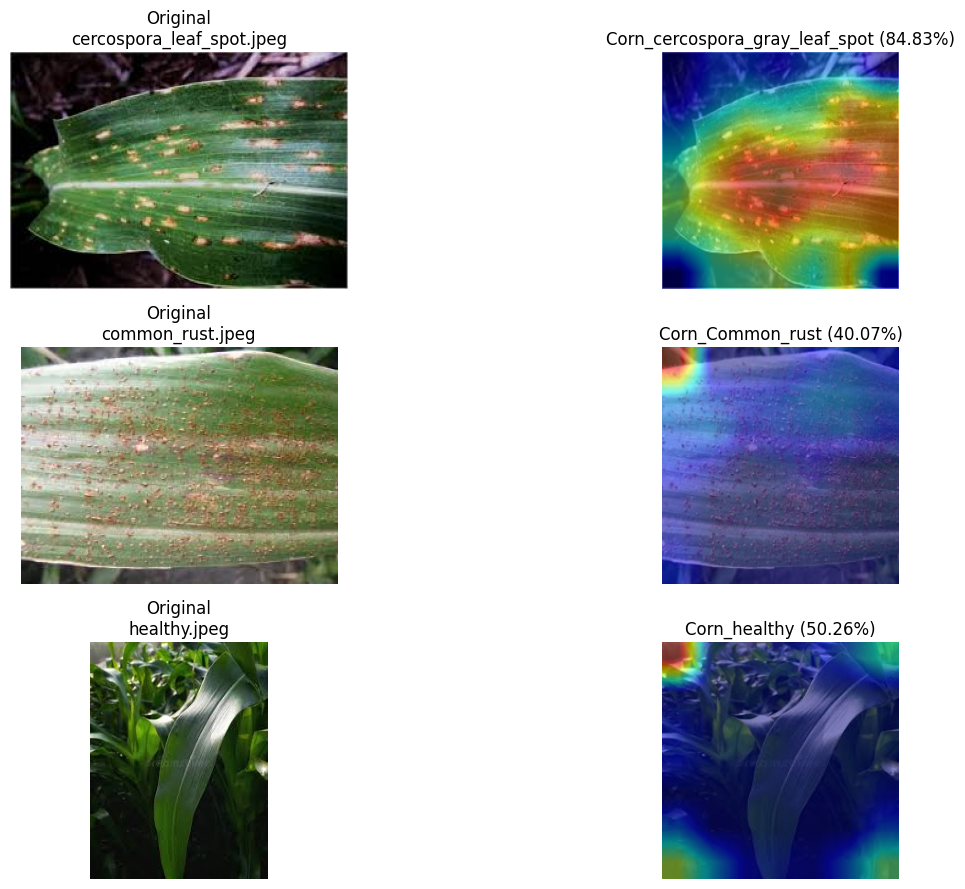

In [23]:
def visualize_batch(model, image_folder):
    image_paths = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    plt.figure(figsize=(15, len(image_paths) * 3))

    for i, img_path in enumerate(image_paths, 1):
        img_pil = Image.open(img_path).convert('RGB')
        input_tensor = transform(img_pil).unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            outputs = model(input_tensor)
            probs = torch.nn.functional.softmax(outputs, dim=1)[0]
            pred_idx = torch.argmax(probs).item()
            pred_class = class_names[pred_idx]
            confidence = probs[pred_idx].item() * 100

        target_layers = [model.conv_head]
        cam = GradCAM(model=model, target_layers=target_layers)
        targets = [ClassifierOutputTarget(pred_idx)]
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]
        rgb_img = np.array(img_pil.resize((IMG_SIZE, IMG_SIZE))) / 255.0
        visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

        plt.subplot(len(image_paths), 2, 2*i-1)
        plt.imshow(img_pil)
        plt.title(f"Original\n{os.path.basename(img_path)}")
        plt.axis('off')

        plt.subplot(len(image_paths), 2, 2*i)
        plt.imshow(visualization)
        plt.title(f"{pred_class} ({confidence:.2f}%)")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

visualize_batch(model, IMAGES_DIR)
